# Project Report - Data

In [34]:
# Imports for the code below
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from tqdne.dataset import WaveformDataset
from tqdne.conf import Config 
from tqdne.representations import CenteredMaxEnvelope, GlobalMaxEnvelope, Representation

# Config object contains the general parameters for the experiment
config = Config()

## Introduction

Earthquakes, natural phenomena characterized by sudden and violent shaking of the ground, are among the most devastating disasters that humanity faces. The seismic waves generated by earthquakes propagate through the Earth's crust, spreading destruction and posing significant challenges for disaster preparedness and response efforts. In recent years, the application of AI techniques has revolutionized various scientific domains, including seismology. Particularly, the emergence of generative AI models has opened new avenues for simulating complex phenomena with unprecedented accuracy, which can be used as reliable inputs to fuel the increasingly data-hungryness of state-of-the-art machine learning models. 

In this project report, we explore the earthquake dataset that will be used during this project. The final goal is to harness popular generative models, in particular GANs, to create high-quality synthetic seismic waveform records with a fixed magnitude and distance from hypocenter, and tackle the natural scarcity of such data.

## Earthquake Data

The dataset used for this project is a modified version of the strong motion dataset from Japan <https://www.kyoshin.bosai.go.jp/>. This dataset containes the peak ground amplitudes for three channel seismograms, with more than 200,000 records. The data was collected from sensors all over Japan. 

Each three-channel waveform comes annotated with the magnitude and the distance of the sensor to the epicenter of the earthquake, as well as three other properties of the specific earthquake. However, for simplicity we focus our exploration on the magnitude and distance from the epicenter of each waveform, as they are believed to be the most impactful for the generation.

Moreover, for simplicity once more, we focus our approach on the first of the three channels of the waveforms.

The basic handling of the dataset is done in `tqdne.dataset` from which
- `build_dataset` parses the dataset file in format .h5, splits into train and test sets, and computes standard deviation and means for the features. For sake of completeness it also produces filtered waveforms, but that will not be used during this project.

- `WaveformDataset` is the dataset class that loads from the preprocessed files output by `build_dataset`. In particular, it is attached to a Representation module and an option to set the exact length of the waveforms, which we fix as 1024 for convenience. We will soon explain what is a Representation module.

A simple demonstration of how to create and sample from the dataset follows.

In [3]:
train_path = config.datasetdir / Path(config.data_upsample_train)
test_path = config.datasetdir / Path(config.data_upsample_test)
wfdataset_train = WaveformDataset(train_path, reduced=1024)
wfdataset_test = WaveformDataset(test_path, reduced=1024)

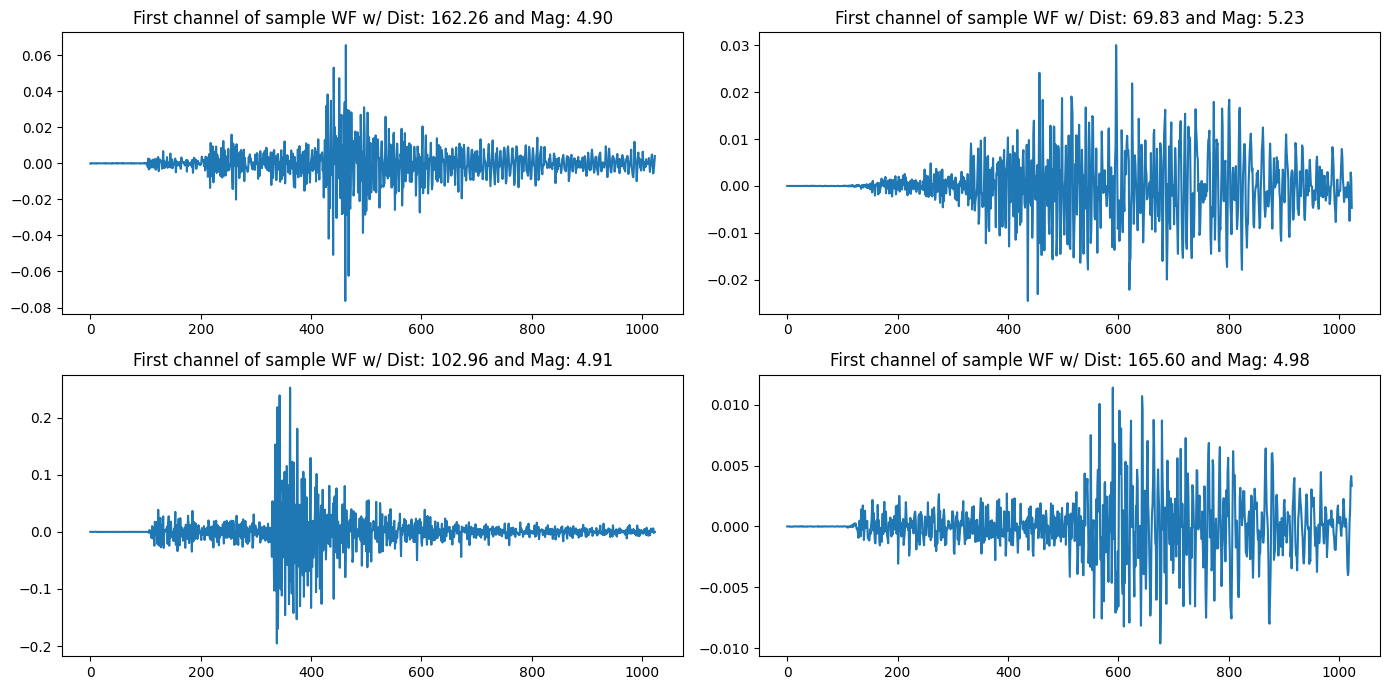

In [16]:
num_plots = 2
# Create a figure and axes
fig, axs = plt.subplots(num_plots, num_plots, figsize=(14, 7))

# Take samples from the dataset
for i in range(num_plots):
    for j in range(num_plots):
        sample_idx = i * num_plots + j
        sample = wfdataset_train[sample_idx]
        sample["cond"] = sample["cond"] * wfdataset_train.features_stds + wfdataset_train.features_means
        title = f"First channel of sample WF w/ Dist: {sample['cond'][0]:.2f} and Mag: {sample['cond'][1]:.2f}"
        waveform = sample["high_res"] # Get the first channel
        axs[i, j].plot(waveform.numpy().squeeze())
        axs[i, j].set_title(title)

plt.tight_layout()
plt.show()

Now we move to explaining the modifyers associated with the dataset.

## Representations

A **Representation module** is essentially a pair of functions, one which applies a transformation to the input data, and the other which approximately inverts this transformation. 

For our use case, we use *enveloping representations*, i.e. we compute an envelope of the waveform which represents a certain characteristic, then we divide the waveform by the envelope pointwise, using the latter as a normalization, and return the concatenation as channels of the log of the envelope and the normalized waveform. 

For sake of clarity, we include a generic implementation below:

In [6]:
# This is a simple example of a envelope function
get_envelope = lambda x: x
inverse_envelope = lambda x: x

class GenericRepresentation(Representation):
    def _get_representation(self, signal):
        envelope = get_envelope(signal)
        norm_signal = signal / envelope
        return np.concatenate([np.log10(envelope), norm_signal])
    def _invert_representation(self, representation):
        envelope = inverse_envelope(10 ** representation[:len(representation)//2])
        signal = representation[len(representation)//2:] * envelope
        return signal

Note that we use the log of the envelope to improve the numerical estability, as we can observe that there is a high variance on the amplitude of the sample waves.

The representations are implemented in `tqdne.representations`. Currently implemented and used for this project are:
- `CenteredMaxEnvelope` which uses the maximum of elements around each point of the waveform as an envelope.
- `GlobalMaxEnvelope` which uses the maximum of the absolute value of the entire waveform as a constant envelope.

We will see how these work in practice below.

### Centered Max Envelope Representation

First we need to redefine the dataset by using the desired envelope. Notice that we stick with the same reductions to the dataset: only two features are used: Distance and Magnitude and the length of the waves is subsampled to 1024.

In [9]:
envelope = CenteredMaxEnvelope(config)
wfdataset_centeredmax = WaveformDataset(train_path, reduced=1024, representation=envelope)

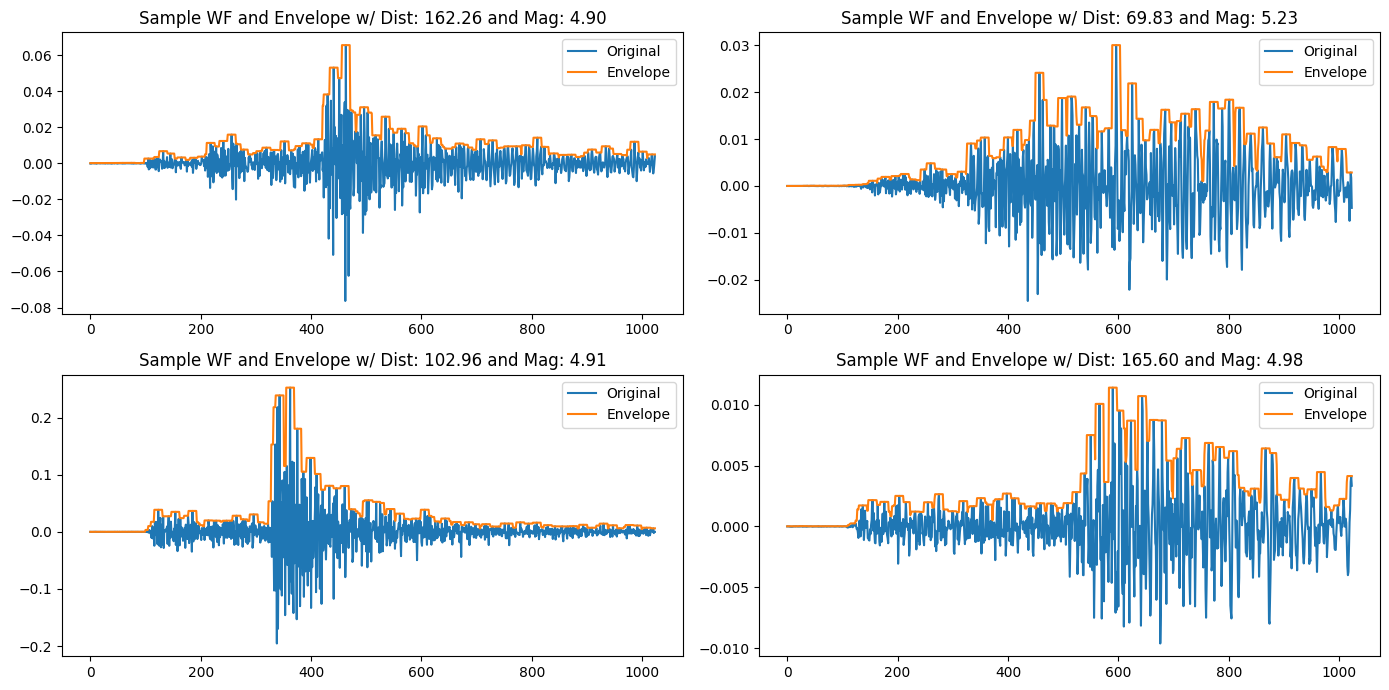

In [26]:
num_plots = 2
# Create a figure and axes
fig, axs = plt.subplots(num_plots, num_plots, figsize=(14, 7))

for i in range(num_plots):
    for j in range(num_plots):
        sample_idx = i * num_plots + j
        sample = wfdataset_centeredmax[sample_idx]
        sample["cond"] = sample["cond"] * wfdataset_centeredmax.features_stds + wfdataset_centeredmax.features_means
        title = f"Sample WF and Envelope w/ Dist: {sample['cond'][0]:.2f} and Mag: {sample['cond'][1]:.2f}"

        # The log envelope is the first half of the representation
        waveform = 10 ** sample["high_res"][0]# Get the first channel
        axs[i, j].plot(envelope.invert_representation(sample["high_res"]).squeeze(), label="Original")
        axs[i, j].plot(waveform.numpy().squeeze(), label="Envelope")
        axs[i, j].set_title(title)
        axs[i, j].legend()
        
plt.tight_layout()
plt.show()

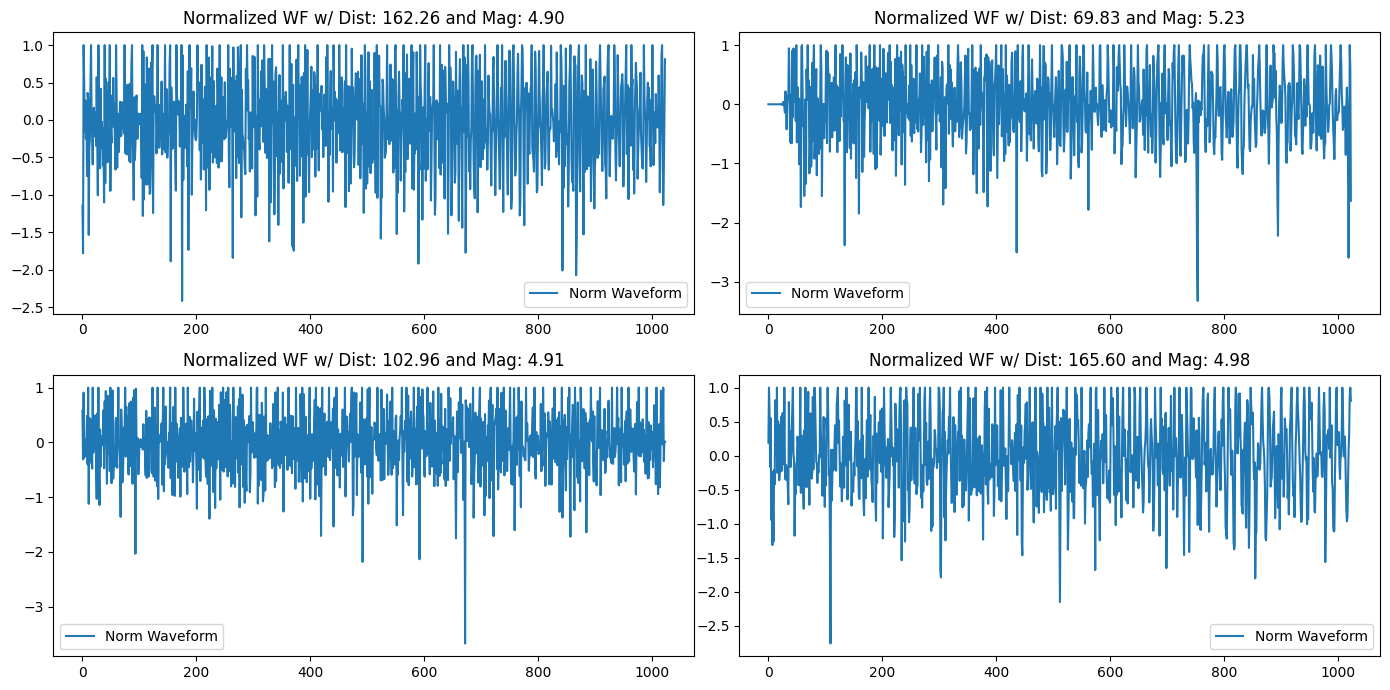

In [29]:
num_plots = 2
# Create a figure and axes
fig, axs = plt.subplots(num_plots, num_plots, figsize=(14, 7))

for i in range(num_plots):
    for j in range(num_plots):
        sample_idx = i * num_plots + j
        sample = wfdataset_centeredmax[sample_idx]
        sample["cond"] = sample["cond"] * wfdataset_centeredmax.features_stds + wfdataset_centeredmax.features_means
        title = f"Normalized WF w/ Dist: {sample['cond'][0]:.2f} and Mag: {sample['cond'][1]:.2f}"

        # The second channel of the high_res is the normalized waveform
        waveform = sample["high_res"][1]
        axs[i, j].plot(waveform.numpy().squeeze(), label="Norm Waveform")
        axs[i, j].set_title(title)
        axs[i, j].legend()
        
plt.tight_layout()
plt.show()

### Global Max Envelope Representation

In [31]:
envelope = GlobalMaxEnvelope(config)
wfdataset_globalmax = WaveformDataset(train_path, reduced=1024, representation=envelope)

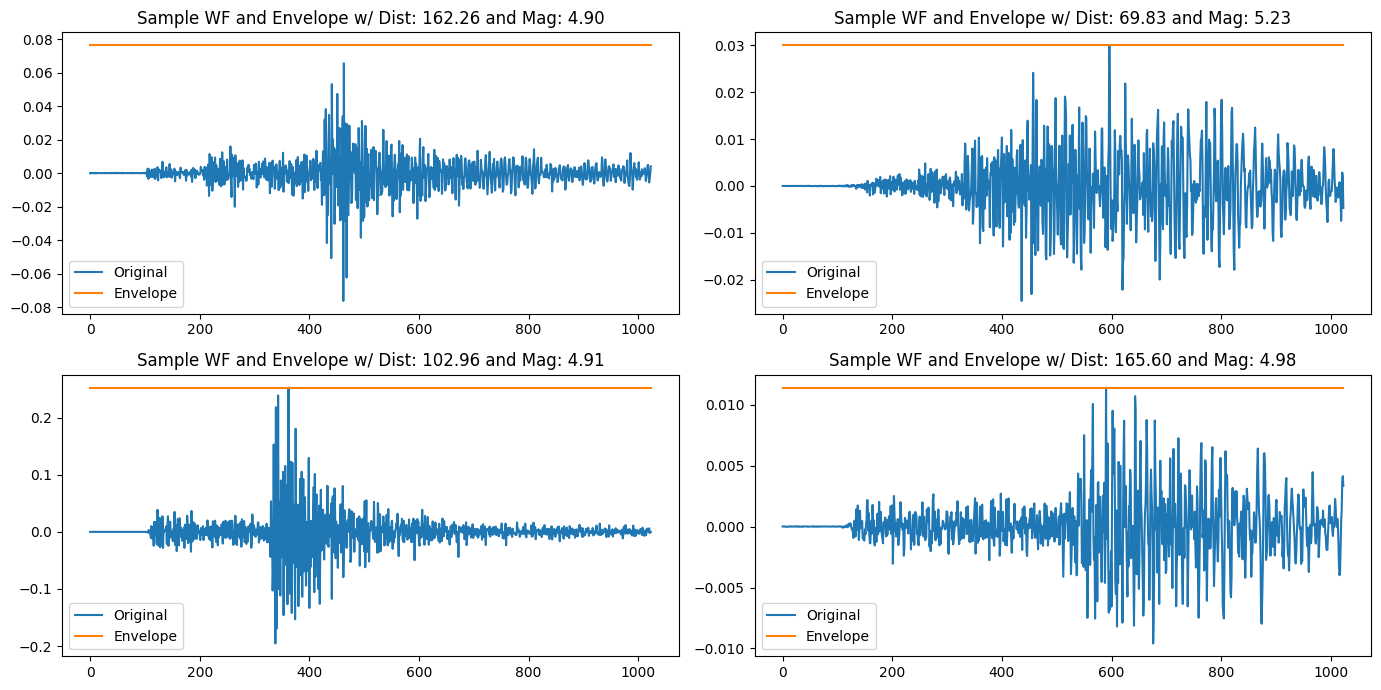

In [32]:
num_plots = 2
# Create a figure and axes
fig, axs = plt.subplots(num_plots, num_plots, figsize=(14, 7))

for i in range(num_plots):
    for j in range(num_plots):
        sample_idx = i * num_plots + j
        sample = wfdataset_globalmax[sample_idx]
        sample["cond"] = sample["cond"] * wfdataset_globalmax.features_stds + wfdataset_globalmax.features_means
        title = f"Sample WF and Envelope w/ Dist: {sample['cond'][0]:.2f} and Mag: {sample['cond'][1]:.2f}"

        # The log envelope is the first half of the representation
        waveform = 10 ** sample["high_res"][0]# Get the first channel
        axs[i, j].plot(envelope.invert_representation(sample["high_res"]).squeeze(), label="Original")
        axs[i, j].plot(waveform.numpy().squeeze(), label="Envelope")
        axs[i, j].set_title(title)
        axs[i, j].legend()
        
plt.tight_layout()
plt.show()

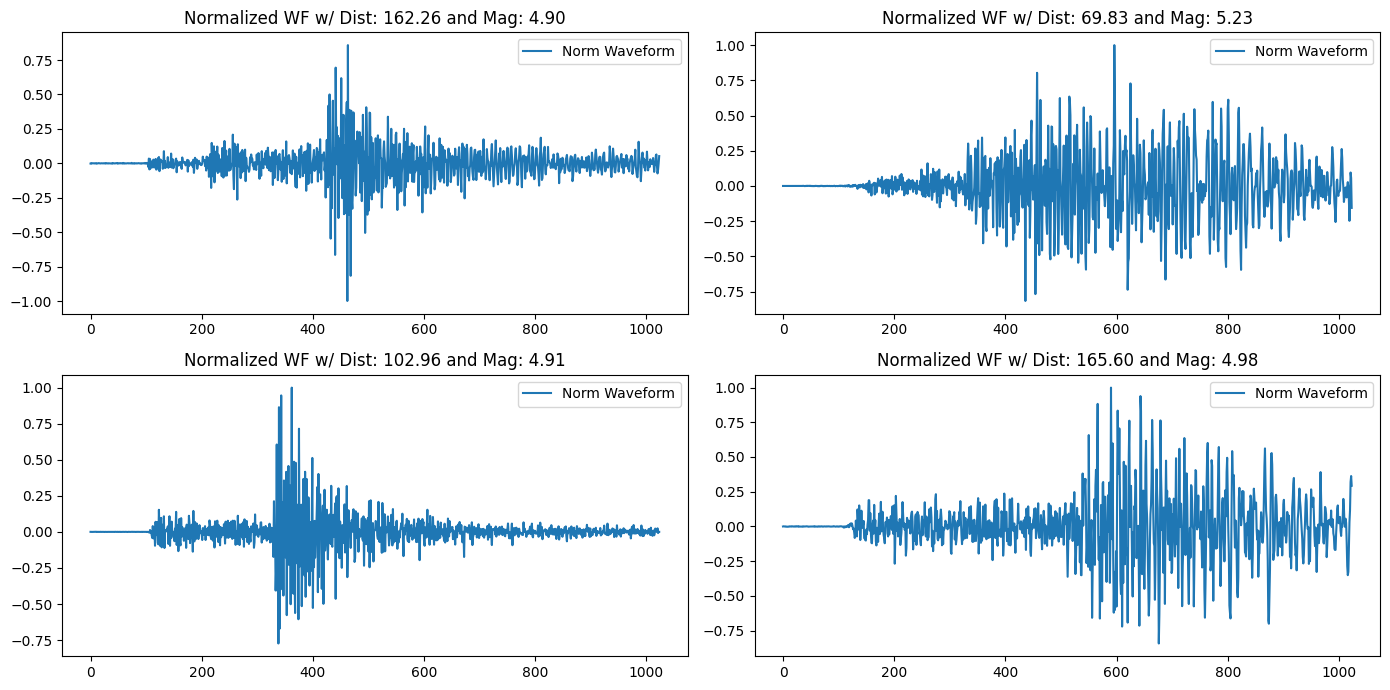

In [33]:
num_plots = 2
# Create a figure and axes
fig, axs = plt.subplots(num_plots, num_plots, figsize=(14, 7))

for i in range(num_plots):
    for j in range(num_plots):
        sample_idx = i * num_plots + j
        sample = wfdataset_globalmax[sample_idx]
        sample["cond"] = sample["cond"] * wfdataset_globalmax.features_stds + wfdataset_globalmax.features_means
        title = f"Normalized WF w/ Dist: {sample['cond'][0]:.2f} and Mag: {sample['cond'][1]:.2f}"

        # The second channel of the high_res is the normalized waveform
        waveform = sample["high_res"][1]
        axs[i, j].plot(waveform.numpy().squeeze(), label="Norm Waveform")
        axs[i, j].set_title(title)
        axs[i, j].legend()
        
plt.tight_layout()
plt.show()